# Population structurée

In [1]:
library(phyclust)
library(coala)

activate_ms(priority = 500)
n=100 # taille de l'échantillon
loc=10000 # nombre de locus
L=1000 # taille de chaque locus 

N=10000 # taille de la population
mu=2*10^(-8) # taux de mutation par base et par génération
theta=2*N*mu

Loading required package: ape


# Les modèles de population structurée

Regardons les arbres de coalescence sous deux modèles différents avec taille constante :

1. Population panmictique
2. Population structurée (exemple, le n-islands model)



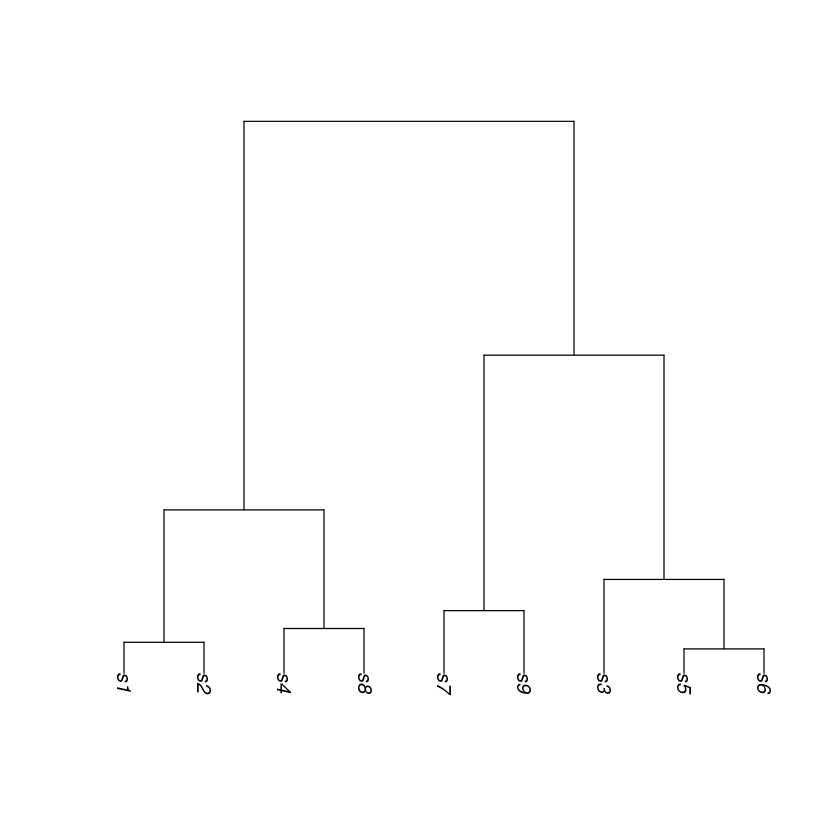

In [2]:
# Modele panmictique
model <- coal_model(sample_size=9,loci_number=loc, loci_length=L,ploidy=1) + 
          sumstat_trees()
res <- simulate(model)
tree=read.tree(text=res$trees[[1]])
plot(tree,show.tip.label=TRUE,no.margin=FALSE,direction="downwards")



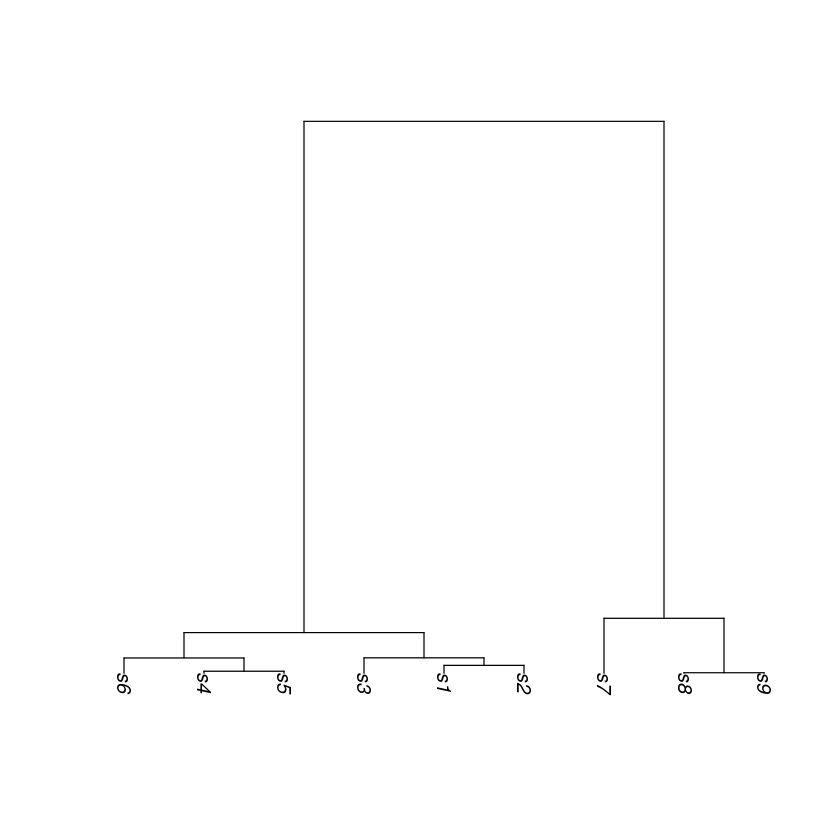

In [3]:
model <- coal_model(sample_size=c(3, 3, 3),loci_number=loc, loci_length=L,ploidy=1) + 
  feat_migration(0.1, symmetric = TRUE) + sumstat_trees()
res <- simulate(model)
tree=read.tree(text=res$trees[[1]])
plot(tree,show.tip.label=TRUE,no.margin=FALSE,direction="downwards")

Refaire les simulations en variant les paramètres de migration. ** Qu'est-ce qu'on observe ? **

# Déficit en hétérozygotes dû à la structuration en sous-populations

On considère une population structurée en sous-populations. Ex: 5 islands de taille $N$ ![n-islands model](./nislands.png)

On considère un locus bi-allelique avec les allèles **a** et **A**. On appelle $p_{i}$ la fréquence de l'allèle **A** dans la sous-population $i$. La fréquence de l'allèle **a** dans la sous-population $i$ est donc $(1-p_{i})$. On supose que les individus se reproduisent au hassard (*random-mating*) à l'intérieur de chaque sous-population. La fréquence d'hétérozygotes **Aa** à l'intérieur de la sous-population $i$ est égale à :

$$2p_{i}(1-p_{i})$$

La fréquence de l'alléle **A** dans la population globale est égale à :
$$\bar{p}=\frac{1}{n}\displaystyle\sum_{i=1}^{n}p_{i}$$

Sous l'hypothèse de *random-mating* au niveau de toute la population, la fréquence d'hétérozygotes devrait être égale à :
$$H_{T}=2\bar{p}(1-\bar{p})$$

La fréquence d'hétérozygotes à l'intérieur d'une île est $2p_{i}(1-p_{i})$. Si on calcule la moyenne des fréquences d'hétérozygotes à l'intérieur d'une île on a :

$$H_{S} = \frac{1}{n}\displaystyle\sum_{i=1}^{n}2p_{i}(1-p_{i})$$ 

**Exercice de calcul: ** En utilisant que $Var(p) = E(p^{2}) - \Big(E(p)\Big)^{2}$ montrer que :

$$H_{S} = 2\bar{p}(1 - \bar{p}) - 2Var(p)$$

On a donc 
$$H_{S} = H_{T} - 2Var(p)$$

ce qui veut dire qu'on aura un déficit en hétérozygotes (moins de diversité) à l'intérieur des îles.

Définition: IBS
------------------

On dira que deux gènes sont **IBS** (*Identic By State*) s'ils ont exactement égaux (ils ont le même alléle). Sous certaines hypothèses cela veut dire qu'il n y a pas eu de mutation dans les ligées des deux gènes entre le présent et l'ancêtre comun le plus récent. 

Pour les cas d'un locus bi-allélique on voit que :

$$Prob(IBS_{T}) = 1 - H_{T} = p^{2} + (1 - p)^{2}$$

$$Prob(IBS_{S}) = 1 - H_{S} = p_{i}^{2} + (1 - p_{i})^{2}$$

on notera : $\bar{f} = Prob(IBS_{T})$, la fréquence de locus IBS dans la population globale et $f_{0} = Prob(IBS_{S})$, la fréquence de locus IBS à l'intérieur d'une sous-population.

Définition: le $F_{ST}$
---------------------------

Le $F_{ST}$ est défini (voir Herbots 1994) en fonction la probabilité de deux gènes d'être "identique" (*IBS*, *Identical By State*) :

$$F_{ST} = \frac{f_0 - \bar{f}}{1 - \bar{f}}$$

avec $f_0$ la probabilité que deux gènes dans la même sous-population soient identiques et $\bar{f}$ la probabilité que deux gènes choisis au hassard dans l'ensemble de la population soient identiques

Dans une population *panmictique* le $F_{ST}$ devrait être égale à zéro (ou proche de zéro en pratique). Cela peut s'expliquer par le fait que la probabilité d'être **IBS** si on prend un sous-ensemble de l'échantillon doit être très proche de la probabilité d'être **IBS** dans l'ensemble de toute la population.

Nous allons simuler des données sous un modèle de population panmictique et nous allons calculer le $F_{ST}$. Nous allons faire de même pour un modèle de population structurée (le n-islands model).


In [4]:
#######  Quelques fonctions utiles ###################

# Probabilité d'IBS
pIBS <- function(simResults, populationSamplesIDs){
  # Calcule la probabilité d'être identique
  # simResults : resultats d'une simulation avec coala
  # populationSamplesIDs : un vecteur avec les indices des séquences à considérer
  nbSequences <- length(populationSamplesIDs)
  nbSites <- length(simResults$seg_sites)
  ibsTemp <- 0
  for(i in 1:nbSites){
    subpop <- as.matrix(simResults$seg_sites[[i]]$snps[populationSamplesIDs, ])
    haplotypes <- apply(subpop, MARGIN = 1, paste, collapse="")
    haplotypesTab <- table(haplotypes)
    identicalPairs <- sum(choose(haplotypesTab, 2))
    totalPairs <- choose(nbSequences, 2)
    ibsTemp <- ibsTemp + identicalPairs/totalPairs
  }
  return(ibsTemp/nbSites)
}

# Calcul du Fst 
computef0 <- function(simResults, samplesInPopList){
  nbSubPop <- length(samplesInPopList)
  f0temp <- 0
  for(samplesIds in samplesInPopList){
    f0temp <- f0temp + pIBS(simResults, samplesIds)
  }
  f0 <- f0temp / nbSubPop
  return(f0)
}
computeFst <- function(simResults, samplesInPopList){
  totalSampleSize <- dim(simResults$seg_sites[[1]]$snps)[1]
  fBar <- pIBS(simResults, 1:totalSampleSize)
  f0 <- computef0(simResults, samplesInPopList) 
  Fst <- (f0 - fBar)/(1 - fBar)
  return(Fst)
}


In [5]:
# Le Fst dans un modèle panmictique devrait être égale à zéro.

# Modèle panmictique (pas de difference entre $f_0_$ et $\bar{f})
model <- coal_model(sample_size=100,loci_number=loc, loci_length=L,ploidy=1) + 
  feat_mutation(rate=theta*L) + sumstat_seg_sites()

res <- simulate(model)
samplesInPopList <- list(1:20, 21:40, 41:60, 61:80, 81:100)
Fst <- computeFst(res, samplesInPopList)
print(paste("Le Fst vaut :", Fst))

[1] "Le Fst vaut : 0.000261647201598171"


In [6]:
# Modèle de population structurée. n-islands avec n=5 et M=1
structModel <- coal_model(sample_size=c(20, 20, 20, 20, 20), loci_number=loc, loci_length=L,ploidy=1) + 
  feat_migration(1, symmetric = TRUE) + feat_mutation(rate=theta*L) + sumstat_seg_sites()

structRes <- simulate(structModel)
samplesInPopList <- list(1:20, 21:40, 41:60, 61:80, 81:100)
Fst <- computeFst(structRes, samplesInPopList)
print(paste("Le Fst vaut :", Fst))

[1] "Le Fst vaut : 0.328740752092298"


# Estimation du flux de gènes

Il est possible d'estimer le taux de migration ($Nm$) à partir de la valeur du $F_{ST}$ (voir Herbots 1994) en se basant sur la formule :

$$Nm\approx \frac{1}{4}\Big(\frac{1}{F_{ST}} - 1 \Big)$$

Nous allons estimer la valeur du $M$ pour un modèle de population structurée. 

In [9]:
# Fonction pour estimer le flux de gènes
estimateM <- function(simResults, samplesInPopList){
  Fst <- computeFst(simResults, samplesInPopList)
  M <- 0.25 * (1.0/Fst - 1)
  return(M)
}

In [10]:
# Modèle de population structurée. n-islands avec n=2 et M=1
structModel_n2 <- coal_model(sample_size=c(20, 20), loci_number=loc, loci_length=L,ploidy=1) + 
  feat_migration(1, symmetric = TRUE) + feat_mutation(rate=theta*L) + sumstat_seg_sites()

structRes <- simulate(structModel_n2)
samplesInPopList <- list(1:20, 21:40)
Fst <- computeFst(structRes, samplesInPopList)
M <- 0.25 * (1.0/Fst - 1)
print(paste("Le Fst vaut :", Fst))
print(paste("Le flux de gènes estimé est :", M))

[1] "Le Fst vaut : 0.174954861433861"
[1] "Le flux de gènes estimé est : 1.17894000173016"


In [11]:
# Modèle de population structurée. n-islands avec n=5 et M=1
structModel_n5 <- coal_model(sample_size=c(20, 20, 20, 20, 20), loci_number=loc, loci_length=L,ploidy=1) + 
  feat_migration(1, symmetric = TRUE) + feat_mutation(rate=theta*L) + sumstat_seg_sites()

structRes <- simulate(structModel_n5)
samplesInPopList <- list(1:20, 21:40, 41:60, 61:80, 81:100)
Fst <- computeFst(structRes, samplesInPopList)
M <- 0.25 * (1.0/Fst - 1)
print(paste("Le Fst vaut :", Fst))
print(paste("Le flux de gènes estimé est :", M))

[1] "Le Fst vaut : 0.329354297627159"
[1] "Le flux de gènes estimé est : 0.509060992375478"


In [13]:
estimFst <- function(nbIslands, MigRate, nbSamplesPerIsland, 
                     loc=10000, L=1000, theta=4e-04){
  sampleVector <- rep(nbSamplesPerIsland, nbIslands)
  samplesInPopList <- lapply(1:nbIslands, FUN = function(i){(nbSamplesPerIsland*(i-1)+1):(nbSamplesPerIsland*i)})
  model <- coal_model(sample_size=sampleVector, loci_number=loc, loci_length=L,ploidy=1) + 
    feat_migration(MigRate, symmetric = TRUE) + feat_mutation(rate=theta*L) + sumstat_seg_sites()
  res <- simulate(model)
  Fst <- computeFst(res, samplesInPopList)
  M <- 0.25 * (1.0/Fst - 1)
  return(c(Fst, M))
}